# Import des modules

In [289]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

# Extractions des données

- SIRH
- Evaluation Performance
- Sondage

In [290]:
sirh = pd.read_csv('ExtraitSIRH.csv')
eval_perf = pd.read_csv('ExtraitEvaluationsPerformance.csv')
sondage = pd.read_csv('ExtraitSondage.csv')

# Création du fichier central

- Identifier les colonnes permettant de réaliser des jointures entre les 3 fichiers :
    - ExtraitSIRH = id_employee
    - ExtraitEvaluationsPerformance = eval_number
    - ExtraitSondage = code_sondage


In [291]:
# Modifier des donnes de la colonne "eval_number" de "eval_perf"
eval_perf['eval_number'] = eval_perf['eval_number'].str.replace('E_', '', regex=False).astype(int)

fc_temp = pd.merge(sirh, eval_perf, left_on="id_employee", right_on="eval_number")
fc = pd.merge(fc_temp, sondage, left_on="id_employee", right_on="code_sondage")
#fc.head(5)

# Traitement des données
- Donnéees Uniques, Redondantes, Erronnées, non valides, etc.


In [292]:
# Données uniques
print(f"Colonnes avec des données uniques: {fc.columns[fc.nunique() == 1].tolist()}")
fc.drop((['nombre_heures_travailless','nombre_employee_sous_responsabilite','ayant_enfants']), axis=1, inplace=True)

# Données redondantes
fc.drop((['eval_number','code_sondage','note_evaluation_actuelle']), axis=1, inplace=True)

# Nom de colonne erronees
fc.rename(columns={'augementation_salaire_precedente': 'augmentation_salaire_precedente'}, inplace=True)
fc.rename(columns={'annee_experience_totale': 'annees_experience_totale'}, inplace=True)

# Données erronees
print(fc.groupby(['statut_marital']).size().sort_values(ascending=False))
for col in fc.select_dtypes(include='object').columns:
    fc[col] = fc[col].str.replace('Ã©', 'e', regex=False)
print(fc.groupby(['statut_marital']).size().sort_values(ascending=False))

# Données non valides
fc['augmentation_salaire_precedente'] = fc['augmentation_salaire_precedente'].str.replace(' %', '', regex=False).astype(int)

Colonnes avec des données uniques: ['nombre_heures_travailless', 'nombre_employee_sous_responsabilite', 'ayant_enfants']
statut_marital
MariÃ©(e)       673
CÃ©libataire    470
DivorcÃ©(e)     327
dtype: int64
statut_marital
Marie(e)       673
Celibataire    470
Divorce(e)     327
dtype: int64


# Analyse Dataset Extrait SIRH
- age, genre, revenu_mensuel, statut_marital, departement, poste
- nombre_experiences_precedentes, annee_experience_totale, annees_dans_l_entreprise, annees_dans_le_poste_actuel

### <font color="orange">Extrait SIRH - Analyse du taux de démission</font>
- Focus sur l'age

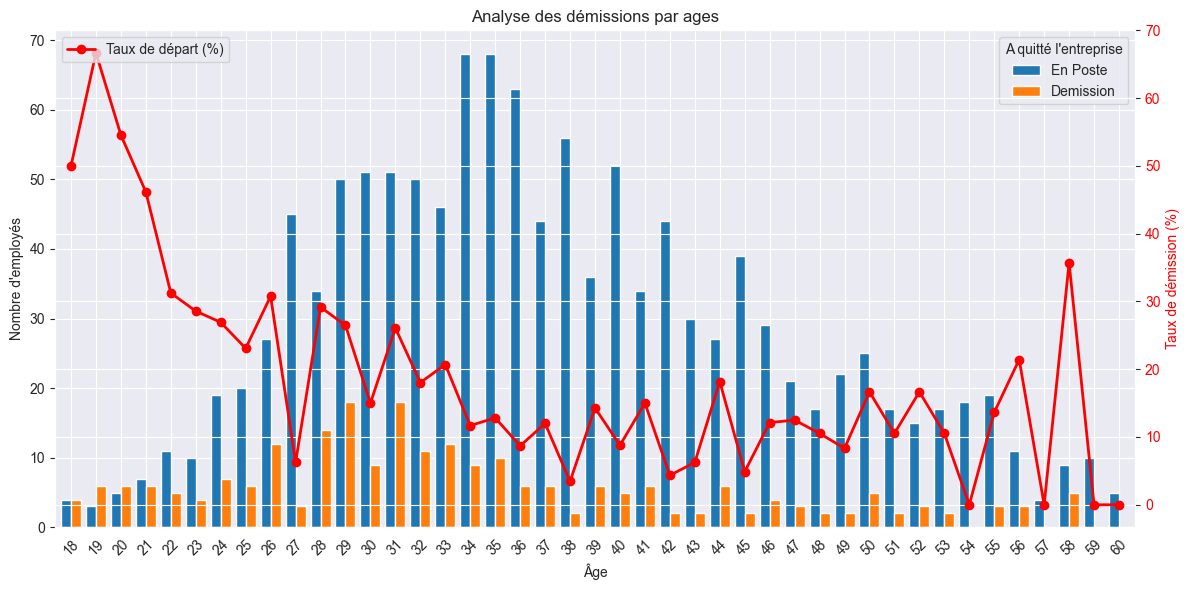

In [293]:
# Groupby sur vos données
grouped = fc.groupby(['age', 'a_quitte_l_entreprise']).size().unstack(fill_value=0)

# Créer la figure avec deux axes Y
fig, ax1 = plt.subplots(figsize=(12, 6))

# Barres sur l'axe principal
grouped.plot(kind='bar', ax=ax1, width=0.8)
ax1.set_xlabel('Âge')
ax1.set_ylabel('Nombre d\'employés')
ax1.legend(title='A quitté l\'entreprise', labels=['En Poste', 'Demission'])
ax1.tick_params(axis='x', rotation=45)

# Créer un deuxième axe Y pour la ligne
ax2 = ax1.twinx()

# Calculer le taux de départ pour la ligne
if grouped.shape[1] == 2:
    taux_depart = (grouped.iloc[:, 1] / grouped.sum(axis=1)) * 100
else:
    taux_depart = (grouped.iloc[:, 0] / grouped.sum(axis=1)) * 100

# Tracer la ligne
ax2.plot(range(len(grouped)), taux_depart.values,
         color='red', marker='o', linewidth=2, markersize=6, label='Taux de départ (%)')
ax2.set_ylabel('Taux de démission (%)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(loc='upper left')

plt.title('Analyse des démissions par ages')
plt.tight_layout()
plt.show()

### <font color="orange">Extrait SIRH - Analyse du taux de démission</font>
- Focus sur le revenu

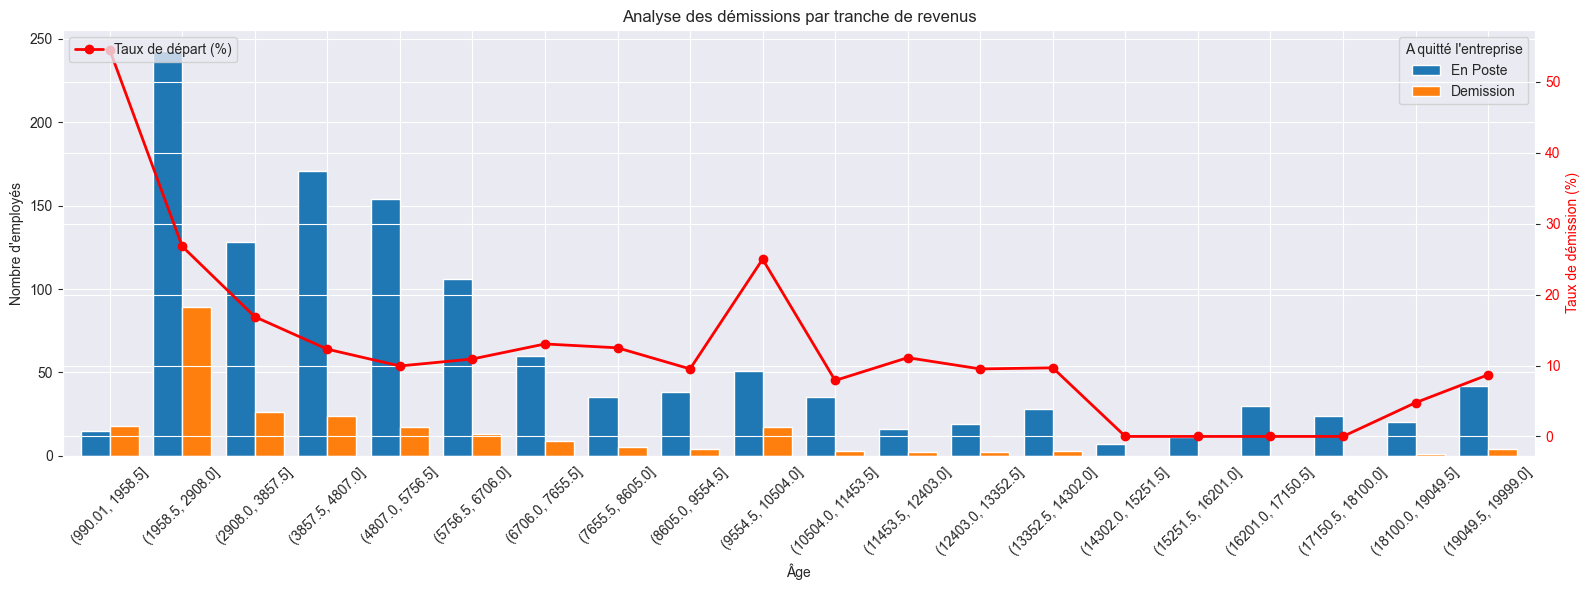

In [294]:
# Créer 20 tranches de revenu
fc['tranche_revenu'] = pd.cut(fc['revenu_mensuel'], bins=20)

# Groupby sur vos données
grouped = fc.groupby(['tranche_revenu', 'a_quitte_l_entreprise'], observed=False).size().unstack(fill_value=0)

# Créer la figure avec deux axes Y
fig, ax1 = plt.subplots(figsize=(16, 6))

# Barres sur l'axe principal
grouped.plot(kind='bar', ax=ax1, width=0.8)
ax1.set_xlabel('Âge')
ax1.set_ylabel('Nombre d\'employés')
ax1.legend(title='A quitté l\'entreprise', labels=['En Poste', 'Demission'])
ax1.tick_params(axis='x', rotation=45)

# Créer un deuxième axe Y pour la ligne
ax2 = ax1.twinx()

# Calculer le taux de départ pour la ligne
if grouped.shape[1] == 2:
    taux_depart = (grouped.iloc[:, 1] / grouped.sum(axis=1)) * 100
else:
    taux_depart = (grouped.iloc[:, 0] / grouped.sum(axis=1)) * 100

# Tracer la ligne
ax2.plot(range(len(grouped)), taux_depart.values,
         color='red', marker='o', linewidth=2, markersize=6, label='Taux de départ (%)')
ax2.set_ylabel('Taux de démission (%)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(loc='upper left')

plt.title('Analyse des démissions par tranche de revenus')
plt.tight_layout()
plt.show()

### <font color="orange">Extrait SIRH - Analyse du pourcentage de démission</font>
- Plusieurs colonnes qualitatives


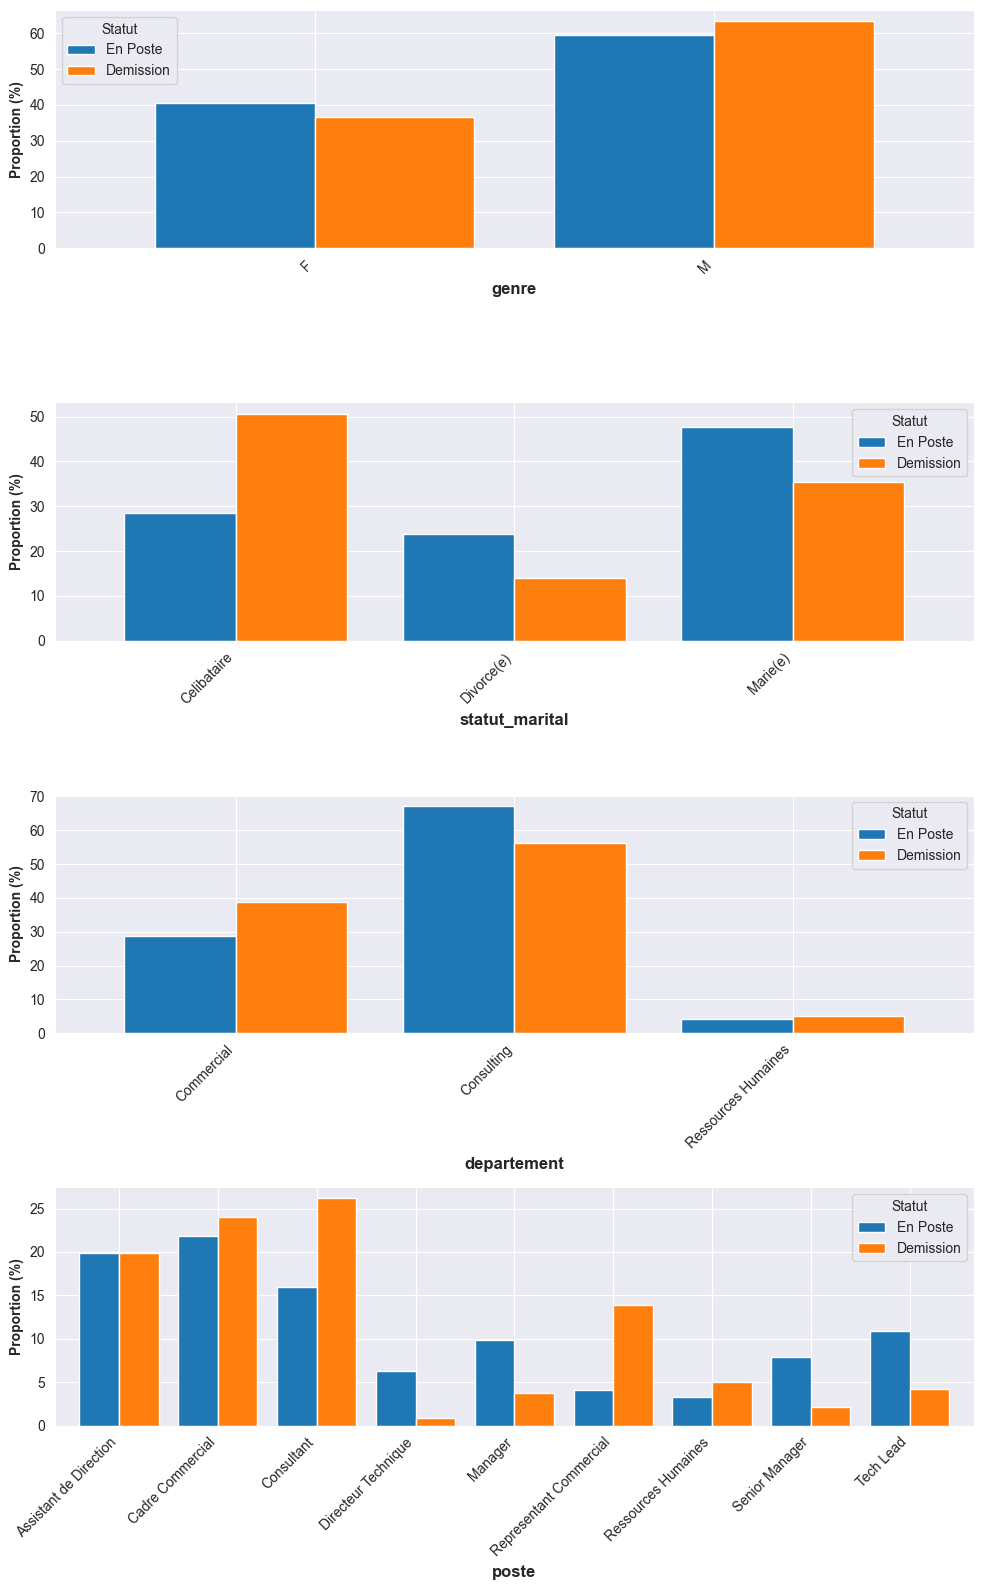

In [295]:
# Liste des colonnes catégorielles à comparer
colonnes_categorielles = ['genre', 'statut_marital', 'departement', 'poste']

# Calculer les proportions pour chaque catégorie par groupe
proportions_list = []

for col in colonnes_categorielles:
    # Calculer les proportions pour chaque valeur de la variable catégorielle
    prop = fc.groupby(['a_quitte_l_entreprise', col], observed=True).size().unstack(fill_value=0)
    # Normaliser pour avoir des proportions (en %)
    prop = prop.div(prop.sum(axis=1), axis=0) * 100
    proportions_list.append(prop)

# Créer des subplots pour chaque variable catégorielle
fig, axes = plt.subplots(len(colonnes_categorielles), 1, figsize=(10, 4*len(colonnes_categorielles)))

for i, col in enumerate(colonnes_categorielles):
    prop = proportions_list[i]
    prop.T.plot(kind='bar', ax=axes[i], width=0.8)

    axes[i].set_xlabel(col, fontweight='bold', fontsize=12)
    axes[i].set_ylabel('Proportion (%)', fontweight='bold')
    #axes[i].set_title(f'{col}', fontweight='bold', fontsize=12)
    axes[i].legend(['En Poste', 'Demission'], title="Statut")
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

### <font color="orange">Extrait SIRH - Analyse du pourcentage de démission</font>
- Comparaison de plusieurs colonnes quantitatives


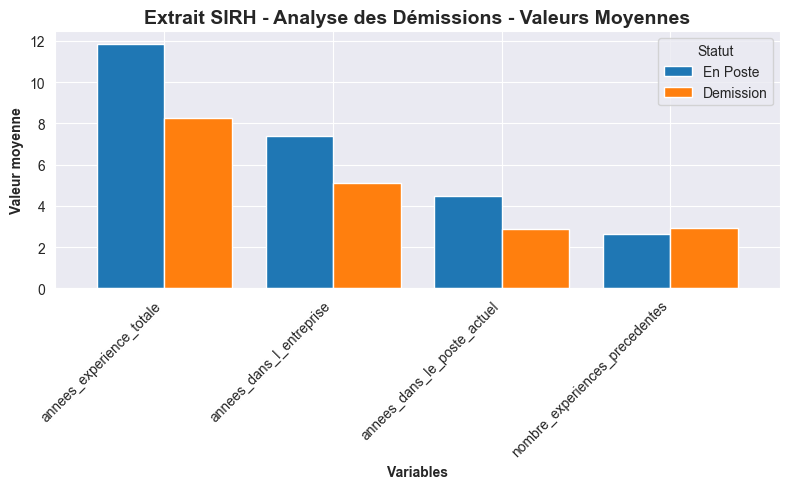

In [296]:
# Liste des colonnes à comparer
colonnes_a_comparer = ['annees_experience_totale', 'annees_dans_l_entreprise', 'annees_dans_le_poste_actuel','nombre_experiences_precedentes']

# Calculer les moyennes pour chaque colonne par groupe
moyennes = fc.groupby('a_quitte_l_entreprise')[colonnes_a_comparer].mean()

# Transposer pour avoir les variables en index
moyennes_transposed = moyennes.T

# Créer le graphique¬
fig, ax = plt.subplots(figsize=(8, 5))
moyennes_transposed.plot(kind='bar', ax=ax, width=0.8)

ax.set_xlabel('Variables', fontweight='bold')
ax.set_ylabel('Valeur moyenne', fontweight='bold')
ax.set_title('Extrait SIRH - Analyse des Démissions - Valeurs Moyennes', fontweight='bold', fontsize=14)
ax.legend(['En Poste', 'Demission'], title="Statut")
ax.set_xticklabels(colonnes_a_comparer, rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Analyse Dataset Extrait Sondage

### <font color="orange">Extrait Sondage - Analyse du pourcentage de démission</font>
- Comparaison de plusieurs colonnes quantitatives

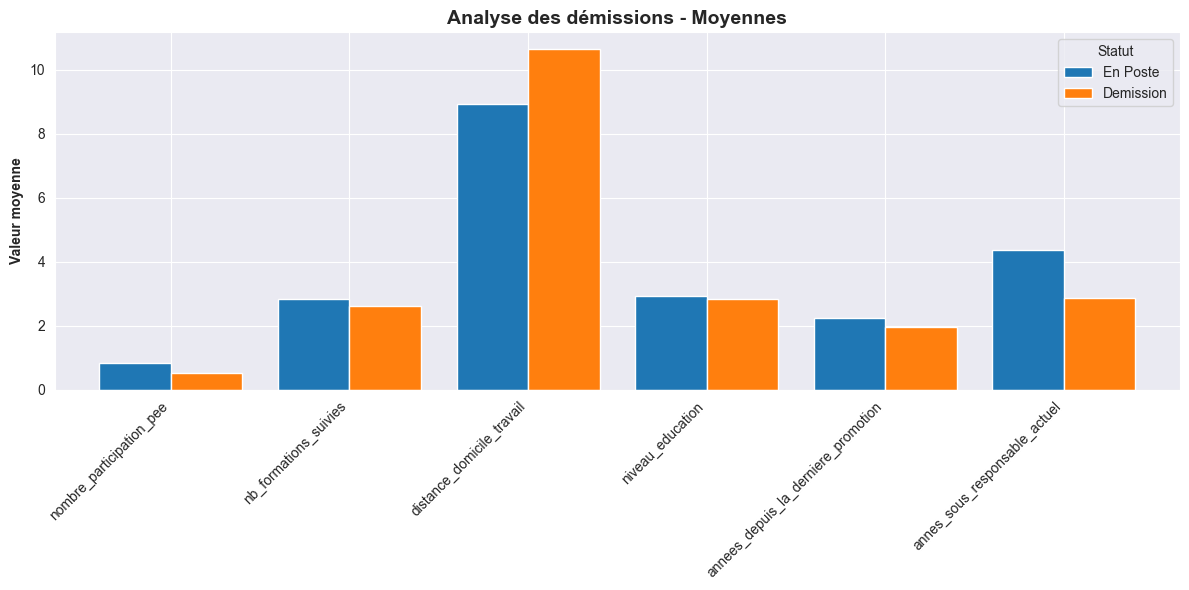

In [297]:
# Liste des colonnes à comparer
colonnes_a_comparer = ['nombre_participation_pee','nb_formations_suivies', 'distance_domicile_travail', 'niveau_education', 'annees_depuis_la_derniere_promotion', 'annes_sous_responsable_actuel' ]

# Calculer les moyennes pour chaque colonne par groupe
moyennes = fc.groupby('a_quitte_l_entreprise')[colonnes_a_comparer].mean()

# Transposer pour avoir les variables en index
moyennes_transposed = moyennes.T

# Créer le graphique
fig, ax = plt.subplots(figsize=(12, 6))
moyennes_transposed.plot(kind='bar', ax=ax, width=0.8)

#ax.set_xlabel('Variables', fontweight='bold')
ax.set_ylabel('Valeur moyenne', fontweight='bold')
ax.set_title('Analyse des démissions - Moyennes', fontweight='bold', fontsize=14)
ax.legend(['En Poste', 'Demission'], title="Statut")
ax.set_xticklabels(colonnes_a_comparer, rotation=45, ha='right')

plt.tight_layout()
plt.show()

### <font color="orange">Extrait Sondage - Analyse du pourcentage de démission</font>
- Comparaison de plusieurs colonnes qualitatives

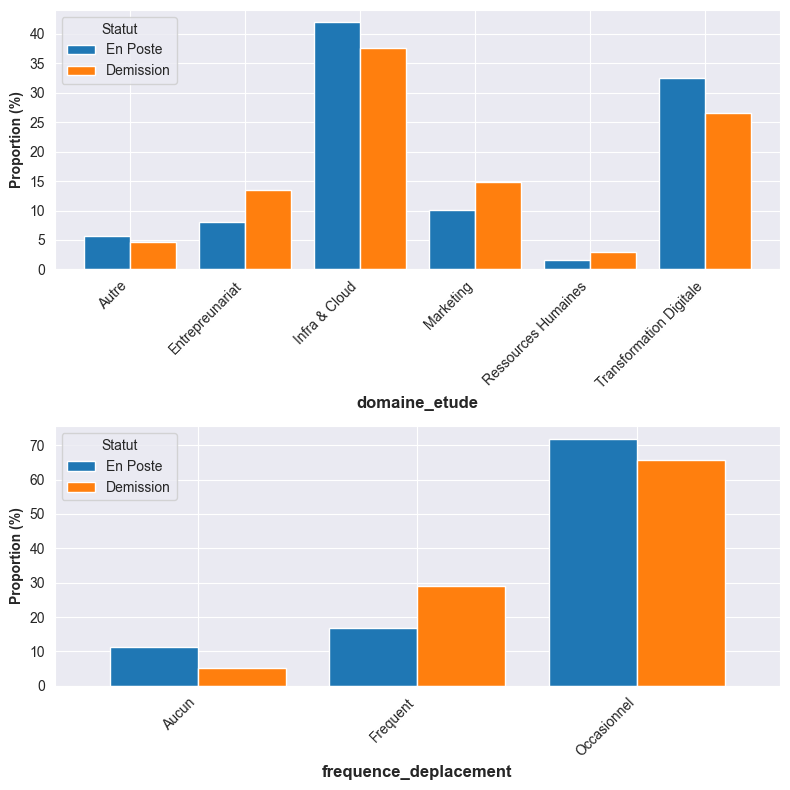

In [298]:
# Liste des colonnes catégorielles à comparer
colonnes_categorielles = ['domaine_etude', 'frequence_deplacement']

# Calculer les proportions pour chaque catégorie par groupe
proportions_list = []

for col in colonnes_categorielles:
    # Calculer les proportions pour chaque valeur de la variable catégorielle
    prop = fc.groupby(['a_quitte_l_entreprise', col]).size().unstack(fill_value=0)
    # Normaliser pour avoir des proportions (en %)
    prop = prop.div(prop.sum(axis=1), axis=0) * 100
    proportions_list.append(prop)

# Créer des subplots pour chaque variable catégorielle
fig, axes = plt.subplots(len(colonnes_categorielles), 1, figsize=(8, 4*len(colonnes_categorielles)))

for i, col in enumerate(colonnes_categorielles):
    prop = proportions_list[i]
    prop.T.plot(kind='bar', ax=axes[i], width=0.8)

    axes[i].set_xlabel(col, fontweight='bold', fontsize=12)
    axes[i].set_ylabel('Proportion (%)', fontweight='bold')
    #axes[i].set_title(f'{col}', fontweight='bold', fontsize=12)
    axes[i].legend(['En Poste', 'Demission'], title="Statut")
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Analyse Extrait Evaluations Performances
### <font color="orange">Extrait Evaluations Performances - Analyse du pourcentage de démission</font>
- Comparaison de plusieurs colonnes quantitatives

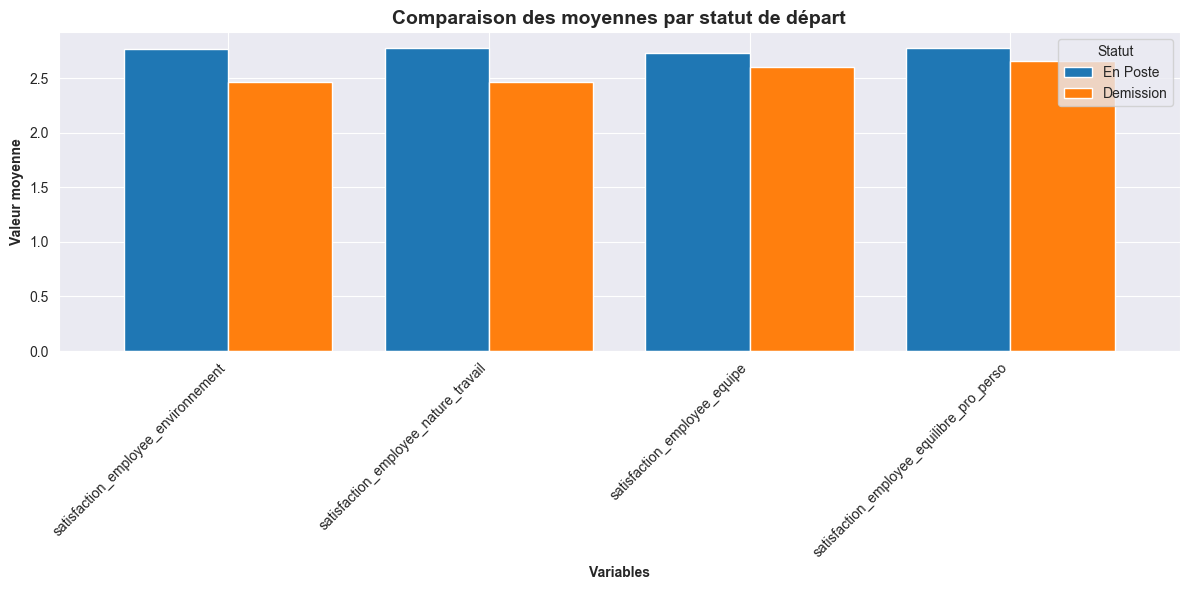

In [299]:
# Liste des colonnes à comparer
colonnes_a_comparer = ['satisfaction_employee_environnement', 'satisfaction_employee_nature_travail', 'satisfaction_employee_equipe', 'satisfaction_employee_equilibre_pro_perso']

# Calculer les moyennes pour chaque colonne par groupe
moyennes = fc.groupby('a_quitte_l_entreprise')[colonnes_a_comparer].mean()

# Transposer pour avoir les variables en index
moyennes_transposed = moyennes.T

# Créer le graphique
fig, ax = plt.subplots(figsize=(12, 6))
moyennes_transposed.plot(kind='bar', ax=ax, width=0.8)

ax.set_xlabel('Variables', fontweight='bold')
ax.set_ylabel('Valeur moyenne', fontweight='bold')
ax.set_title('Comparaison des moyennes par statut de départ', fontweight='bold', fontsize=14)
ax.legend(['En Poste', 'Demission'], title="Statut")
ax.set_xticklabels(colonnes_a_comparer, rotation=45, ha='right')

plt.tight_layout()
plt.show()

### <font color="orange">Extrait Evaluations Performances - Analyse du pourcentage de démission</font>
- Comparaison de plusieurs colonnes qualitatives

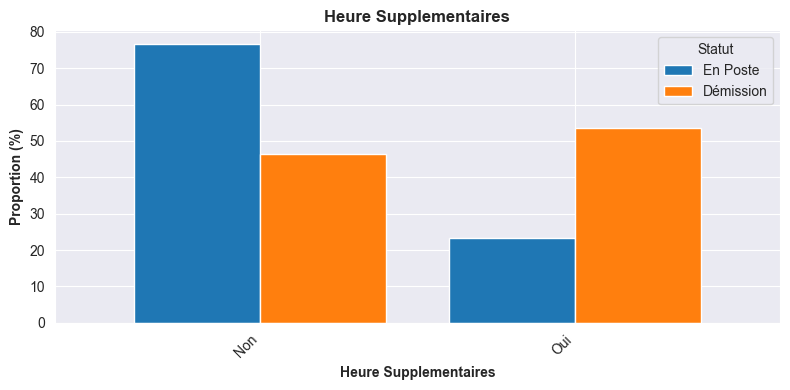

In [300]:
# Liste des colonnes catégorielles à comparer
colonnes_categorielles = ['heure_supplementaires']

# Calculer les proportions pour chaque catégorie par groupe
proportions_list = []

for col in colonnes_categorielles:
    # Calculer les proportions pour chaque valeur de la variable catégorielle
    prop = fc.groupby(['a_quitte_l_entreprise', col], observed=True).size().unstack(fill_value=0)
    # Normaliser pour avoir des proportions (en %)
    prop = prop.div(prop.sum(axis=1), axis=0) * 100
    proportions_list.append(prop)

# Créer le graphique
fig, ax = plt.subplots(figsize=(8, 4))

col = colonnes_categorielles[0]
prop = proportions_list[0]
prop.T.plot(kind='bar', ax=ax, width=0.8)

ax.set_xlabel(col.replace('_', ' ').title(), fontweight='bold')
ax.set_ylabel('Proportion (%)', fontweight='bold')
ax.set_title(f'{col.replace("_", " ").title()}', fontweight='bold', fontsize=12)
ax.legend(['En Poste', 'Démission'], title="Statut")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Analyse sur l'ensemble du dataset


### <font color="orange">Création d'un score indicateur "Revenu"</font>
- Plus le score est élevé, plus le salarié est satisfait
    * Revenu Mensuel
    * Augmentation salaire precedente
    * annees depuis la derniere promotion

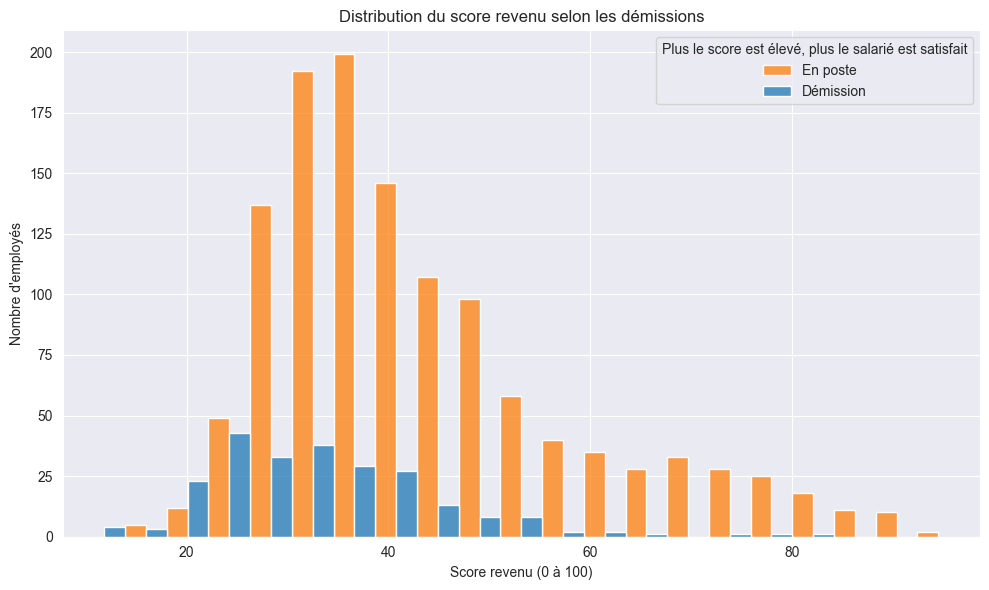

In [301]:
# Indice  normalisé - créer un score global (0 à 100) qui combine tout
scaler = MinMaxScaler()

fc[['revenu_mensuel_norm', 'augmentation_salaire_precedente_norm', 'annees_depuis_la_derniere_promotion_norm']] = scaler.fit_transform(
    fc[['revenu_mensuel', 'augmentation_salaire_precedente', 'annees_depuis_la_derniere_promotion']]
)

# pondérations à ajuster
fc['score_revenu'] = ((
0.6 * fc['revenu_mensuel_norm'] +
0.2 * fc['augmentation_salaire_precedente_norm'] +
0.2 * (1 - fc['annees_depuis_la_derniere_promotion_norm'])  # plus le nb d'annees est eleve plus le score baisse
) * 100).round(2)
#print(fc[['score_revenu']])

fc.drop(['revenu_mensuel_norm','augmentation_salaire_precedente_norm', 'annees_depuis_la_derniere_promotion_norm'], axis=1, inplace=True)

plt.figure(figsize=(10,6))
sns.histplot(
    data=fc,
    x='score_revenu',
    hue='a_quitte_l_entreprise',
    bins=20,
    kde=False,
    multiple='dodge'
)

plt.title("Distribution du score revenu selon les démissions")
plt.xlabel("Score revenu (0 à 100)")
plt.ylabel("Nombre d'employés")
plt.legend(title="Plus le score est élevé, plus le salarié est satisfait", labels=["En poste", "Démission"])
plt.tight_layout()
plt.show()

### <font color="orange">Création d'un score indicateur "Environnement de Travail"</font>
- Plus le score est élevé, plus le salarié est satisfait
    * Annees sous responsable actuel
    * satisfaction employee envirronement, nature travail et equipe

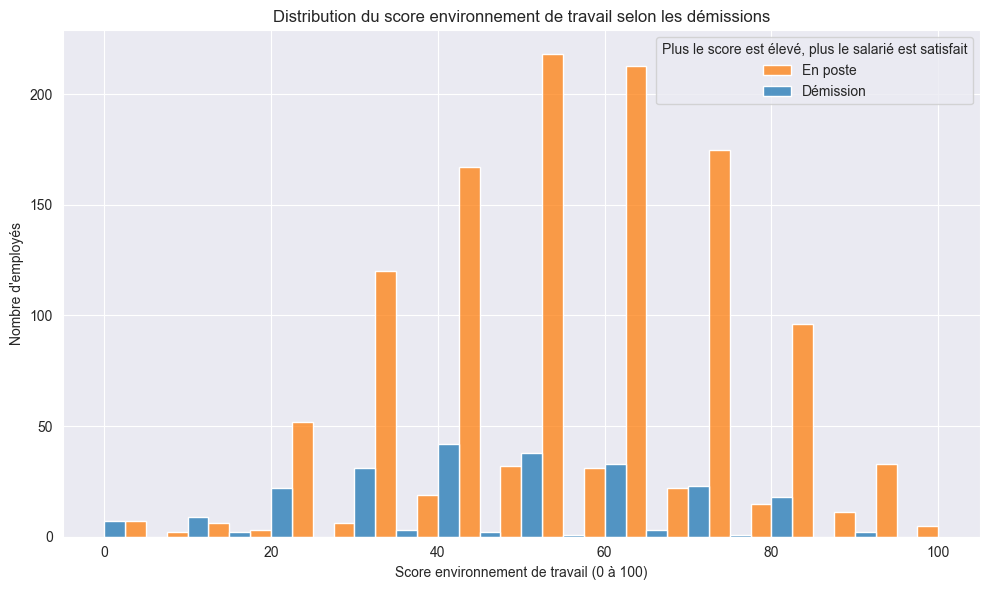

In [302]:
# Indice  normalisé - créer un score global (0 à 100) qui combine tout
scaler = MinMaxScaler()

fc[['annes_sous_responsable_actuel_norm', 'satisfaction_employee_environnement_norm', 'satisfaction_employee_nature_travail_norm', 'satisfaction_employee_equipe_norm']] = scaler.fit_transform(
    fc[['annes_sous_responsable_actuel', 'satisfaction_employee_environnement', 'satisfaction_employee_nature_travail', 'satisfaction_employee_equipe']]
)

# pondérations à ajuster selon ton objectif
fc['score_environnement'] = ((
0.1 * fc['annes_sous_responsable_actuel_norm'] +
0.3 * fc['satisfaction_employee_environnement_norm'] +
0.3 * fc['satisfaction_employee_nature_travail_norm'] +
0.3 * fc['satisfaction_employee_equipe_norm']
) * 100).round(2)
#print(fc[['score_environnement']])

fc.drop(['annes_sous_responsable_actuel_norm','satisfaction_employee_environnement_norm', 'satisfaction_employee_nature_travail_norm', 'satisfaction_employee_equipe_norm'], axis=1, inplace=True)

plt.figure(figsize=(10,6))
sns.histplot(
    data=fc,
    x='score_environnement',
    hue='a_quitte_l_entreprise',
    bins=20,
    kde=False,
    multiple='dodge'
)

plt.title("Distribution du score environnement de travail selon les démissions")
plt.xlabel("Score environnement de travail (0 à 100)")
plt.ylabel("Nombre d'employés")
plt.legend(title="Plus le score est élevé, plus le salarié est satisfait", labels=["En poste", "Démission"])
plt.tight_layout()
plt.show()

### <font color="orange">Création d'un score indicateur "Mobilite"</font>

- Plus le score est élevé, plus le salarié est satisfait
    * Mobilité externe : Le salarié a t-il passé sa carrière dans l'entreprise ?
    * Mobilité interne : Le salarié a-t-il occupé toujours le meme poste avant de démissioner?

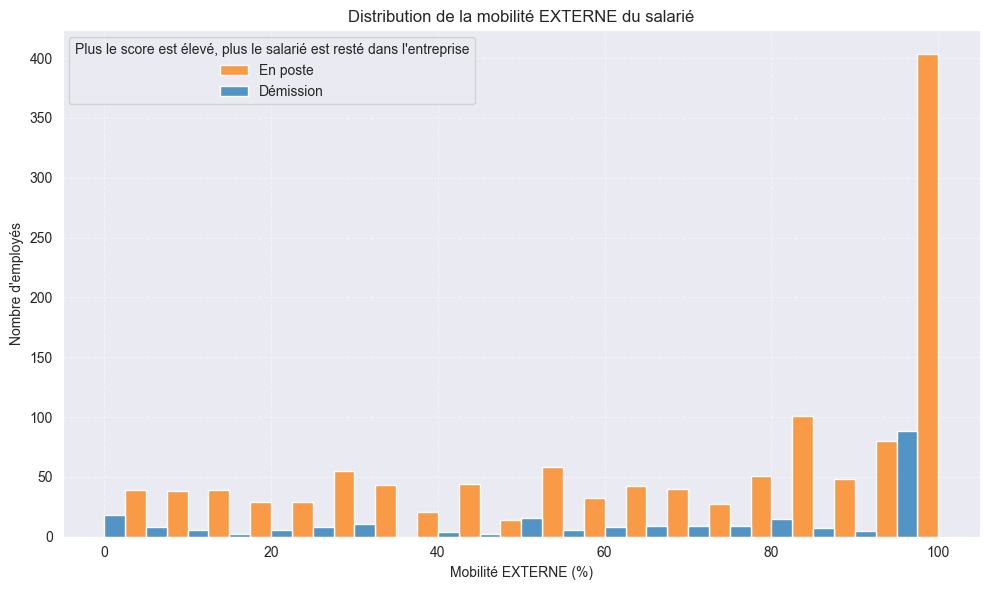

In [303]:
# Mesurer la proportion d’expérience passée dans l’entreprise
fc['mobilite_externe'] = (
    np.where(
        fc['annees_experience_totale'] > 0,
        fc['annees_dans_l_entreprise'] / fc['annees_experience_totale'],
        0  # ← si total = 0, on met 0
    )
)
# La méthode .clip() en pandas sert à borner les valeurs d’une série numérique entre deux limites — un minimum et un maximum.
fc['mobilite_externe'] = fc['mobilite_externe'].clip(0, 1) * 100
fc['mobilite_externe'] = fc['mobilite_externe'].round(2)
#print(fc[['mobilite_externe']])

plt.figure(figsize=(10,6))
sns.histplot(
    data=fc,
    x='mobilite_externe',                # variable sur l’axe X
    hue='a_quitte_l_entreprise',         # séparation selon le départ
    bins=20,                             # nombre de barres
    kde=False,                           # tu peux mettre True pour lisser la courbe
    multiple='dodge'                     # barres côte à côte
)
plt.title("Distribution de la mobilité EXTERNE du salarié")
plt.xlabel("Mobilité EXTERNE (%)")
plt.ylabel("Nombre d'employés")
plt.legend(title="Plus le score est élevé, plus le salarié est resté dans l'entreprise", labels=["En poste", "Démission"])
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

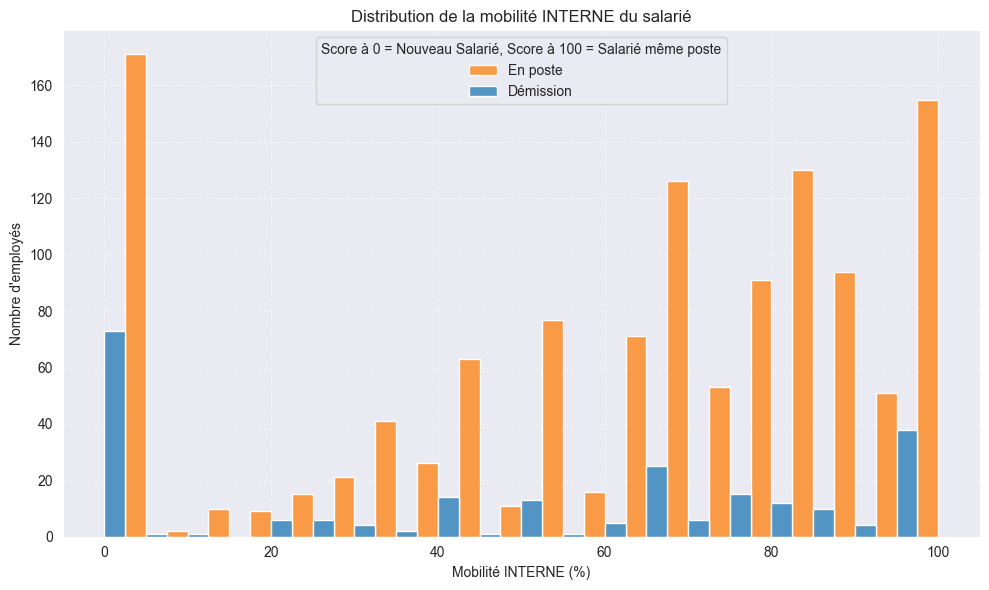

In [304]:
# Mesurer la proportion d’expérience dans le poste actuel
fc['mobilite_interne'] = (
    np.where(
        fc['annees_dans_l_entreprise'] > 0,
        fc['annees_dans_le_poste_actuel'] / fc['annees_dans_l_entreprise'],
        0  # ← si total = 0, on met 0
    )
)
fc['mobilite_interne'] = fc['mobilite_interne'].clip(0, 1) * 100
fc['mobilite_interne'] = fc['mobilite_interne'].round(2)
#print(fc[['mobilite_interne']])

plt.figure(figsize=(10,6))
sns.histplot(
    data=fc,
    x='mobilite_interne',                # variable sur l’axe X
    hue='a_quitte_l_entreprise',         # séparation selon le départ
    bins=20,                             # nombre de barres
    kde=False,                           # tu peux mettre True pour lisser la courbe
    multiple='dodge'                     # barres côte à côte
)

plt.title("Distribution de la mobilité INTERNE du salarié")
plt.xlabel("Mobilité INTERNE (%)")
plt.ylabel("Nombre d'employés")
plt.legend(title="Score à 0 = Nouveau Salarié, Score à 100 = Salarié même poste", labels=["En poste", "Démission"])
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

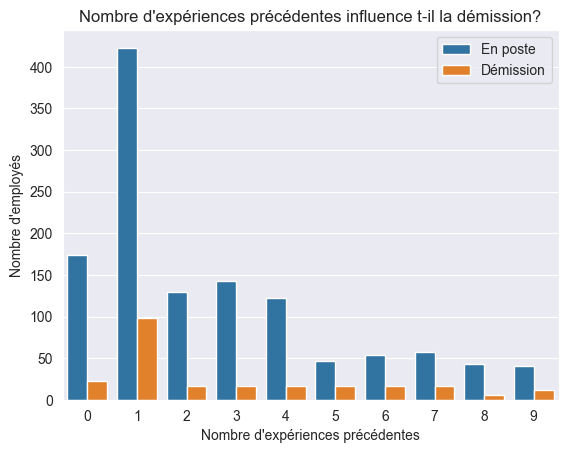

In [305]:
sns.countplot(
    data=fc,
    x='nombre_experiences_precedentes',
    hue='a_quitte_l_entreprise'
)
plt.title("Nombre d'expériences précédentes influence t-il la démission?")
plt.xlabel("Nombre d'expériences précédentes")
plt.ylabel("Nombre d'employés")
plt.legend(title="", labels=["En poste", "Démission"])
plt.show()

### <font color="orange">Score Equilibre Pro/Perso</font>
- Plus le score est élevé, plus le salarié est satisfait
    * Evaluation satisfaction employee equilibre pro perso
    * Distance domicile travail
    * Heures supplémentaires
    * Fréquences déplacements professionnels

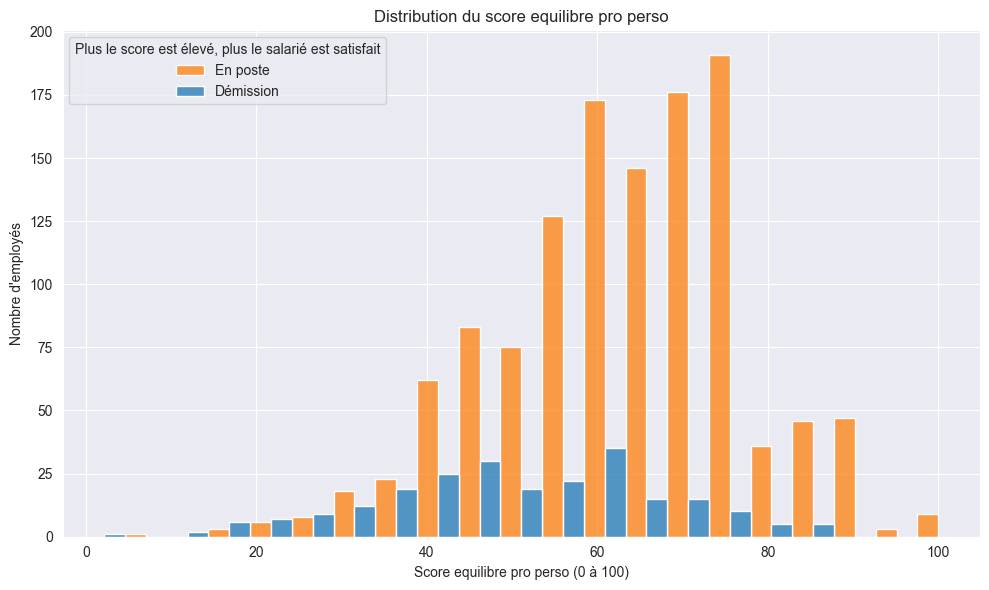

In [306]:
# Indice composite normalisé - créer un score global (0 à 100) qui combine tout
scaler = MinMaxScaler()
fc["heure_supplementaires_norm"] = fc["heure_supplementaires"].map({"Oui":0, "Non":1})
fc["frequence_deplacement_norm"] = fc["frequence_deplacement"].map({"Aucun":1, "Occasionnel":0.5, "Frequent":0})

fc[['satisfaction_employee_equilibre_pro_perso_norm', 'distance_domicile_travail_norm']] = scaler.fit_transform(
    fc[['satisfaction_employee_equilibre_pro_perso', 'distance_domicile_travail']]
)

# pondérations à ajuster selon ton objectif
fc['score_pro_perso'] = ((
0.5 * fc['satisfaction_employee_equilibre_pro_perso_norm'] + # Score élevé = satisfaction
0.1 * fc['heure_supplementaires_norm'] + # Score élevé = satisfaction = 1
0.2 * (1 - fc['distance_domicile_travail_norm']) + # Plus le score est élevé,  plus le salarié est satisfait
0.2 * fc['frequence_deplacement_norm'] # Score élevé = satisfaction = 1
) * 100).round(2)
#print(fc[['score_pro_perso']])
# PLUS LE SCORE EST ELEVE, PLUS LE SALARIE EST SATISFAIT

fc.drop(['heure_supplementaires_norm','frequence_deplacement_norm', 'satisfaction_employee_equilibre_pro_perso_norm', 'distance_domicile_travail_norm'], axis=1, inplace=True)

plt.figure(figsize=(10,6))
sns.histplot(
    data=fc,
    x='score_pro_perso',
    hue='a_quitte_l_entreprise',
    bins=20,
    kde=False,
    multiple='dodge'
)

plt.title("Distribution du score equilibre pro perso")
plt.xlabel("Score equilibre pro perso (0 à 100)")
plt.ylabel("Nombre d'employés")
plt.legend(title="Plus le score est élevé, plus le salarié est satisfait", labels=["En poste", "Démission"])
plt.tight_layout()
plt.show()

# Export CSV

In [307]:
fc.to_csv('fc.csv', index=False)